# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [59]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/xiaotong/Projects/mlfs-book
HopsworksSettings initialized!


In [33]:
import datetime
from datetime import timedelta
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import hopsworks
import json
from mlfs.airquality import util
import os

In [34]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today


datetime.datetime(2025, 11, 17, 21, 34, 1, 329708)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [35]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-17 21:34:02,553 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-17 21:34:02,574 INFO: Initializing external client
2025-11-17 21:34:02,575 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-17 21:34:03,178 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-17 21:34:03,754 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286339


## <span style="color:#ff5f27;">📊 Calculate Rolling Window Feature for Predictions</span>

Before making predictions, we need to calculate the `pm25_rolling_mean_3d` feature for each prediction date.
For each future date, we need to get the PM2.5 values from the previous 3 days.


In [36]:
from datetime import timedelta  
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()

air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
batch_data['pm25_rolling_mean_3d'] = None   

for idx, row in batch_data.iterrows():
    pred_date = row['date']  # pandas.Timestamp

    # pred_date-3, pred_date-2, pred_date-1
    start_date = pred_date - timedelta(days=3)
    end_date   = pred_date - timedelta(days=1)

    historical_pm25 = air_quality_fg.filter(
        (air_quality_fg.country == country) & 
        (air_quality_fg.city == city) & 
        (air_quality_fg.street == street) &
        (air_quality_fg.date >= start_date) &
        (air_quality_fg.date <= end_date)
    ).read()

    historical_pm25 = historical_pm25.sort_values('date')
    historical_pm25 = historical_pm25[historical_pm25['pm25'].notna()]

    if len(historical_pm25) >= 3:
        recent_3 = historical_pm25.tail(3)
        batch_data.loc[idx, 'pm25_rolling_mean_3d'] = recent_3['pm25'].mean()
    elif len(historical_pm25) > 0:
        batch_data.loc[idx, 'pm25_rolling_mean_3d'] = historical_pm25['pm25'].mean()
    else:
        all_hist = air_quality_fg.filter(
            (air_quality_fg.country == country) & 
            (air_quality_fg.city == city) & 
            (air_quality_fg.street == street) &
            (air_quality_fg.date < pred_date)
        ).read()
        if len(all_hist) > 0:
            batch_data.loc[idx, 'pm25_rolling_mean_3d'] = all_hist['pm25'].mean()
        else:
            batch_data.loc[idx, 'pm25_rolling_mean_3d'] = None
            print(f"Warning: No historical PM2.5 data found for date {pred_date}. "
                  f"Rolling window feature set to None.")

batch_data['pm25_rolling_mean_3d'] = batch_data['pm25_rolling_mean_3d'].astype('float32')

print(f"Calculated rolling window features for "
      f"{batch_data['pm25_rolling_mean_3d'].notna().sum()} out of {len(batch_data)} prediction dates")
batch_data


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.90s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.79s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.01s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.70s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.03s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.68s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.72s) 
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.69s) 
Calculated rolling window features for 6 out of 6 pred

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean_3d
0,2025-11-21 00:00:00+00:00,13.30,0.0,14.689588,36.027473,Guilin,95.983673
1,2025-11-22 00:00:00+00:00,13.30,0.0,10.041354,14.534496,Guilin,95.983673
2,2025-11-23 00:00:00+00:00,15.00,0.0,11.503113,20.136398,Guilin,95.983673
3,2025-11-20 00:00:00+00:00,11.75,0.0,13.684735,35.362556,Guilin,95.983673
4,2025-11-19 00:00:00+00:00,9.35,0.0,10.829958,21.447809,Guilin,99.000000
5,2025-11-18 00:00:00+00:00,10.50,0.0,18.391737,40.236294,Guilin,99.000000


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [37]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-17 21:34:59,565 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/559043 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/106486 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/21509 elapsed<00:00 remaining<?

In [38]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='9.7857666E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [39]:
feature_cols = [
    'pm25_rolling_mean_3d',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant',
]

batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[feature_cols]
)
batch_data



,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean_3d,predicted_pm25
0,2025-11-21 00:00:00+00:00,13.30,0.0,14.689588,36.027473,Guilin,95.983673,114.783127
1,2025-11-22 00:00:00+00:00,13.30,0.0,10.041354,14.534496,Guilin,95.983673,143.273117
2,2025-11-23 00:00:00+00:00,15.00,0.0,11.503113,20.136398,Guilin,95.983673,121.288597
3,2025-11-20 00:00:00+00:00,11.75,0.0,13.684735,35.362556,Guilin,95.983673,110.410652
4,2025-11-19 00:00:00+00:00,9.35,0.0,10.829958,21.447809,Guilin,99.000000,121.088097
5,2025-11-18 00:00:00+00:00,10.50,0.0,18.391737,40.236294,Guilin,99.000000,106.955444


In [40]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_rolling_mean_3d         6 non-null      float32                
 7   predicted_pm25               6 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(6), object(1)
memory usage: 368.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [42]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_rolling_mean_3d,predicted_pm25,street,country,days_before_forecast_day
5,2025-11-18 00:00:00+00:00,10.50,0.0,18.391737,40.236294,Guilin,99.000000,106.955444,longyinluxiaoxue,China,1
4,2025-11-19 00:00:00+00:00,9.35,0.0,10.829958,21.447809,Guilin,99.000000,121.088097,longyinluxiaoxue,China,2
3,2025-11-20 00:00:00+00:00,11.75,0.0,13.684735,35.362556,Guilin,95.983673,110.410652,longyinluxiaoxue,China,3
0,2025-11-21 00:00:00+00:00,13.30,0.0,14.689588,36.027473,Guilin,95.983673,114.783127,longyinluxiaoxue,China,4
1,2025-11-22 00:00:00+00:00,13.30,0.0,10.041354,14.534496,Guilin,95.983673,143.273117,longyinluxiaoxue,China,5
2,2025-11-23 00:00:00+00:00,15.00,0.0,11.503113,20.136398,Guilin,95.983673,121.288597,longyinluxiaoxue,China,6


In [43]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 5 to 2
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_rolling_mean_3d         6 non-null      float32                
 7   predicted_pm25               6 non-null      float32                
 8   street                       6 non-null      object                 
 9   country                      6 non-null      object                 
 10  days_before

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

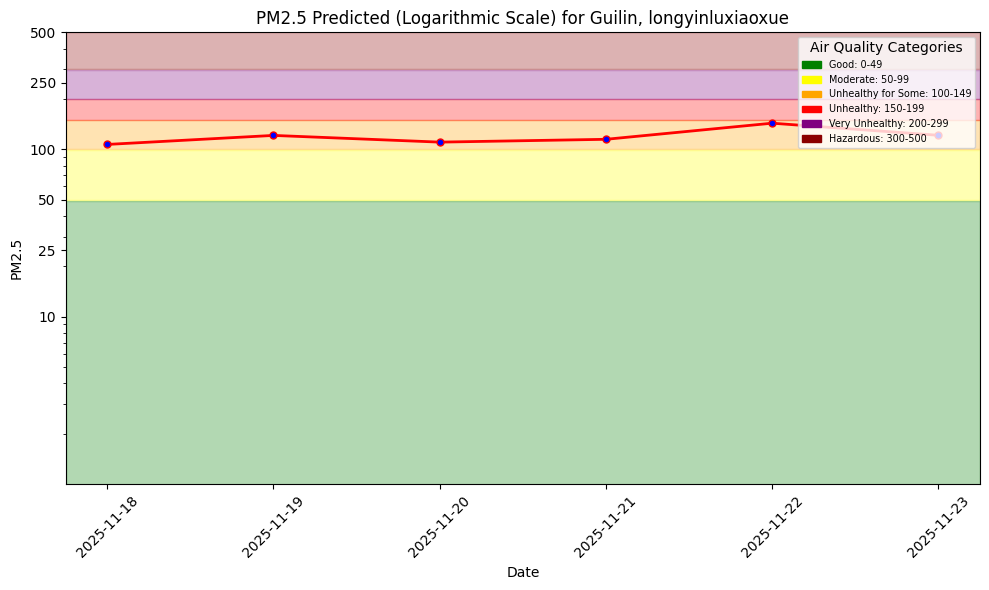

In [44]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [45]:
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    version=2,
    description='Air Quality prediction monitoring with 3d rolling mean',
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [46]:
cols_for_monitor = [
    'date',
    'temperature_2m_mean',
    'precipitation_sum',
    'wind_speed_10m_max',
    'wind_direction_10m_dominant',
    'pm25_rolling_mean_3d',   
    'predicted_pm25',
    'street',
    'city',
    'country',
    'days_before_forecast_day',
]
monitor_fg.insert(batch_data[cols_for_monitor], wait=True)

Uploading Dataframe: 100.00% |████████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1286339/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-17 21:36:03,885 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-17 21:36:10,282 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-17 21:38:01,333 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-17 21:38:04,499 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-17 21:38:04,643 INFO: Waiting for log aggregation to finish.
2025-11-17 21:38:23,122 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [47]:
monitor_fg = fs.get_feature_group(name='aq_predictions', version=2)
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.56s) 


In [48]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=1)
air_quality_df = air_quality_fg.read()
air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.14s) 


,date,pm25,country,city,street,url,pm25_rolling_mean_3d
0,2020-06-06 00:00:00+00:00,51.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,52.333332
1,2019-01-20 00:00:00+00:00,76.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,121.000000
2,2023-03-02 00:00:00+00:00,160.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,153.666672
3,2021-02-15 00:00:00+00:00,103.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,85.000000
4,2024-06-09 00:00:00+00:00,86.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,63.333332
...,...,...,...,...,...,...,...
4283,2025-06-22 00:00:00+00:00,30.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,40.666668
4284,2021-11-21 00:00:00+00:00,40.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,89.666664
4285,2016-01-30 00:00:00+00:00,162.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,136.333328
4286,2023-04-15 00:00:00+00:00,94.0,China,Guilin,longyinluxiaoxue,https://api.waqi.info/feed/@7181,112.000000


In [51]:
import datetime
from datetime import timedelta
import pandas as pd
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import hopsworks
import json
from mlfs.airquality import util
import os

outcome_df = air_quality_df[['date', 'pm25']]
preds_df   = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on='date').sort_values('date')
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(
        weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model
    )
hindcast_df

,date,predicted_pm25,pm25
1,2025-11-14 00:00:00+00:00,82.385841,80.0
0,2025-11-15 00:00:00+00:00,97.737808,100.0
2,2025-11-17 00:00:00+00:00,80.703690,99.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

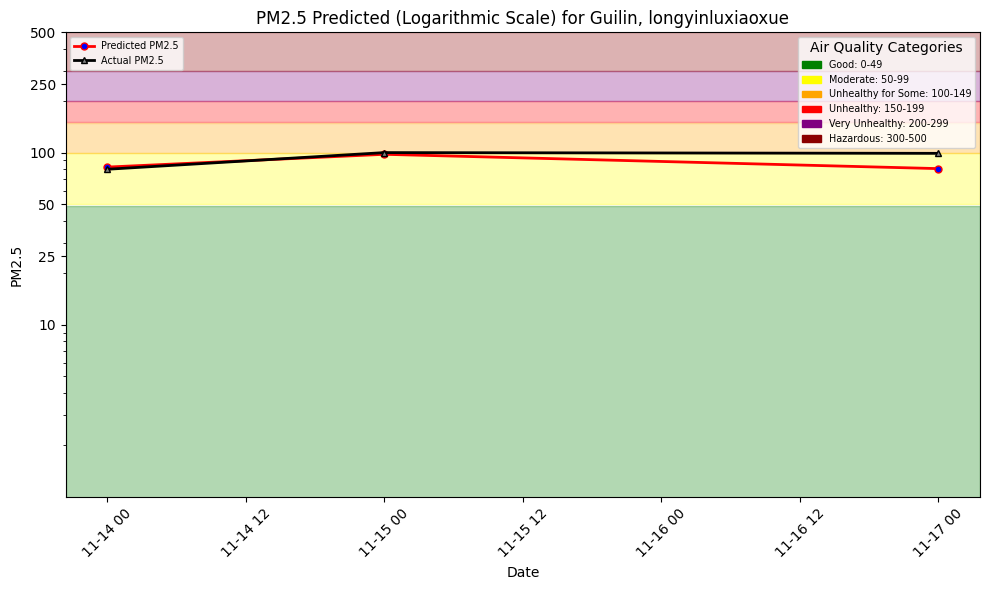

In [52]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [26]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /home/xiaotong/Projects/mlfs-book/docs/air-quality/assets/img/pm25_forecast.png: 0.000%|          | …

Uploading /home/xiaotong/Projects/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day.png: 0.000%|       …

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1286339/settings/fb/path/Resources/airquality


---